In [57]:
#
# Demonstration of low-overhead flexible MPC code on the unstable "F16" test problem.
# Two outputs are supposed to approach their respective reference values while at the same time
# respect hard input contraints and a softened constraint on the first output. Softening makes
# the problem feasible at all times but adds slack variable dimensions to the MPC formulation.
#
# It is easy to pack the problem into a "problem dict" P.
# Each solve uses the provided P with no memory of past solves.
# Therefore it is straightforward to use the solver in adaptive control setups.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
import rempc

In [70]:
# Define continuous-time system matrices
Ac = np.array([[-.151,-60.5651,0,-32.174],
               [-.0001,-1.3411,.9929,0],
               [.00018,43.2541,-.86939,0],
               [0,0,1,0]])

Bc = np.array([[-2.516,-13.136],
               [-.1689,-.2514],
               [-17.251,-1.5766],
               [0,0]])

Cc = np.array([[0,1,0,0],
               [0,0,0,1]])

Dc = np.array([[0.0,0.0],
               [0.0,0.0]])

# Discretization time Ts, and simulation stop time 
Ts = 0.05
Tstop = 12.0

# Zero-order hold --> discrete time system
dtsys = cont2discrete((Ac, Bc, Cc, Dc), Ts)
Ad, Bd, Cd, Dd = dtsys[0], dtsys[1], dtsys[2], dtsys[3]
assert np.all(Dd == 0.0)

In [76]:
# Standard options dict
Ompc = rempc.options_qpmpclti2f()
print(Ompc.keys())

# Setup LTI/MPC problem dict
Pmpc = {'A' : Ad, 'B' : Bd, 'C' : Cd, 'D' : Dd}

# Length of horizon: 0..n
Pmpc.update({'n' : int(15)})

Pmpc['w'] = np.array([[0.0]])  # dynamics bias term

y2ref = 10
Pmpc['r'] = np.array([0, y2ref], dtype = float).reshape(2, 1)
Pmpc['x'] = np.zeros((4, 1))  # this will be edited each time step
Pmpc['W'] = np.array([[1.0]])
Pmpc['Qx'] = np.array([[1.0e-6]])
Pmpc['R'] = np.array([[1.0e-3]])

# the state constraints are essential for this problem
# both inputs are box-bounded abs(.)<=25
umax = 25.0
umin = -25.0

# and the output y2 is boxed such that -1/2<=y2<=1/2
y1max = 0.5 
y1min = -0.5

# F1*x + F2*u <= f3
Pmpc['F1'] = np.vstack((np.zeros((2, 4)), np.zeros((2, 4)), Pmpc['C'][0, :], -1.0 * Pmpc['C'][0, :]))
Pmpc['F2'] = np.vstack((np.eye(2), -1.0 * np.eye(2), np.zeros((2, 2))))
Pmpc['f3'] = np.array([umax, umax, -umin, -umin, y1max, -y1min]).reshape(6, 1)

# Specify constraint softening for rows 5 and 6 (0-based: 4, 5)
# (corresponding to the y1 limits); this is indicated
# by positive elements in the .sc vector (the respective slack costs).
Pmpc['sc'] = np.array([-1, -1, -1, -1, 5e2, 5e2], dtype = float).reshape(6, 1)

# Input noise (uncertainty/error) std about 1% of max allowed range.
# Generate as w=B*d, d=randn(2,1)*sgmd;
sgmd = 0.01 * (umax - umin) / 2

# During the simulation; do not even bother
# to return the full MPC solution; just output the first control sample.
# And discard both state and slack trajectories from return dict.
Pmpc['xreturn'] = int(0) # do not return state trajectory prediction
Pmpc['ureturn'] = int(1) # only return first control sample from solution path
Pmpc['sreturn'] = int(0) # do not return slack variable

print(Pmpc.keys())

dict_keys(['verbosity', 'maxiters', 'ep', 'eta', 'expl_sparse', 'chol_update', 'blas_suite', 'refinement'])
dict_keys(['A', 'B', 'C', 'D', 'n', 'w', 'r', 'x', 'W', 'Qx', 'R', 'F1', 'F2', 'f3', 'sc', 'xreturn', 'ureturn', 'sreturn'])


In [77]:
# Start the control loop simulation run until Tstop
kmax = int(np.ceil(Tstop / Ts))

tsim = Ts * np.arange(kmax)
xsim = np.tile(0.0, (kmax, 4))
usim = np.tile(np.nan, (kmax, 2))
ysim = np.tile(np.nan, (kmax, 2))
rsim = np.tile(np.nan, (kmax, 2))
wsim = np.tile(np.nan, (kmax, 4))
tclk = np.tile(np.nan, (kmax, 3))
itrs = np.tile(np.nan, (kmax, ))
k = 0

print('Closed-loop simulating #{} time-steps with Ts={:.4f}...\n'.format(kmax, Ts))

while True:
  x0 = xsim[k, :]
  ysim[k, :] = np.dot(Cd, x0)
  Pmpc['x'] = x0.reshape((x0.size, 1))

  if Pmpc['r'][1] == y2ref and np.abs(ysim[k, 1] - y2ref) / y2ref < 1.0e-2:
    Pmpc['r'][1] = 0.0
  elif Pmpc['r'][1] == 0.0 and np.abs(ysim[k, 1]) < 2.0e-2:
    Pmpc['r'][1] = y2ref
    
  rsim[k, :] = Pmpc['r'].flatten()
    
  R1 = rempc.qpmpclti2f(Pmpc, Ompc)
  assert R1['isconverged'] == 1
    
  itrs[k] = R1['iters']
  tclk[k, 0] = R1['totalclock']
  tclk[k, 1] = R1['solveclock']
  tclk[k, 2] = R1['cholyclock']
    
  u0 = R1['utraj'][0, :]
  d = sgmd * np.random.randn(2)
  w = np.dot(Bd, d)
  x1 = np.dot(Ad, x0) + np.dot(Bd, u0) + w  # evolve system; stochastic disturbance w and MPC control sample u0
  usim[k, :] = u0.flatten()
  wsim[k, :] = w.flatten()
  k += 1
  if k == kmax:
    break;
  xsim[k, :] = x1

print('done (avg. IPM iterations = {:.2f}).'.format(np.mean(itrs)))

Closed-loop simulating #240 time-steps with Ts=0.0500...

done (avg. IPM iterations = 22.14).


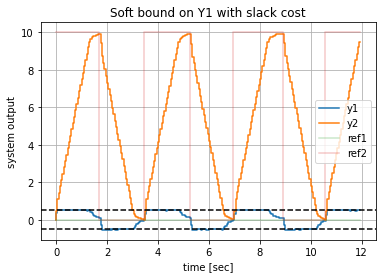

In [78]:
plt.step(tsim, ysim[:, 0], label = 'y1')
plt.step(tsim, ysim[:, 1], label = 'y2')
plt.step(tsim, rsim[:, 0], label = 'ref1', alpha = 0.25)
plt.step(tsim, rsim[:, 1], label = 'ref2', alpha = 0.25)
plt.axhline(y1min, linestyle = '--', color = 'k')
plt.axhline(y1max, linestyle = '--', color = 'k')
plt.legend()
plt.grid(True)
plt.xlabel('time [sec]')
plt.ylabel('system output')
plt.title('Soft bound on Y1 with slack cost')
plt.show()

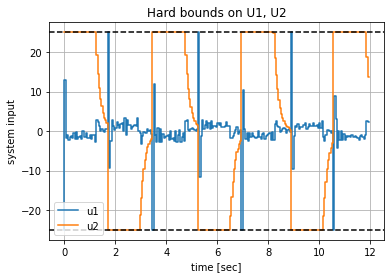

In [79]:
plt.step(tsim, usim[:, 0], label = 'u1')
plt.step(tsim, usim[:, 1], label = 'u2')
plt.axhline(umin, linestyle = '--', color = 'k')
plt.axhline(umax, linestyle = '--', color = 'k')
plt.legend()
plt.grid(True)
plt.xlabel('time [sec]')
plt.ylabel('system input')
plt.title('Hard bounds on U1, U2')
plt.show()

In [82]:
print('median solve time (per sample):  {:.3f} msec'.format(1.0e3 * np.median(tclk[0, :])))
print('minimum solve time (per sample): {:.3f} msec'.format(1.0e3 * np.min(tclk[0, :])))
print('(sample time is {:.3f} msec)'.format(1.0e3 * Ts))

median solve time (per sample):  2.649 msec
minimum solve time (per sample): 1.118 msec
(sample time is 50.000 msec)
